In [2]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asap/python')
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asap')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
import asapc 
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

import joblib

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet(data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_path()
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [3]:
dl.load_data()
asap = ASAPP(adata=dl,factorization='VB', max_iter=100)
asap.get_pbulk()

In [4]:
asap.pbulk_mat.shape

(573, 13745)

In [5]:

K = 5
nmfm = asapc.ASAPNMFAlt(asap.pbulk_mat.T,K)
nmf = nmfm.run()

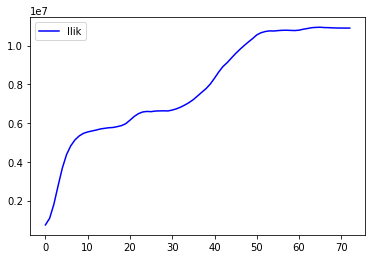

In [6]:
plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

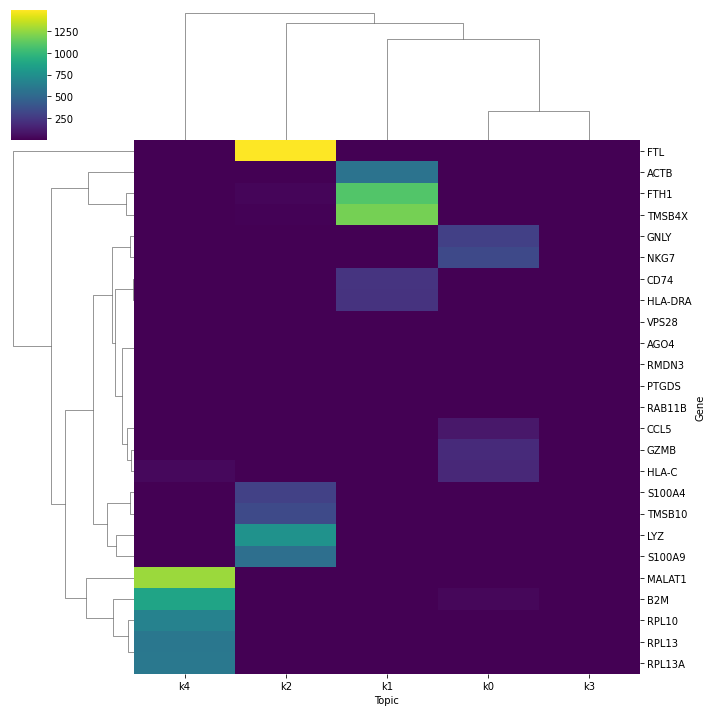

In [7]:
df_beta = pd.DataFrame(nmf.beta.T)
df_beta.columns = dl.cols
df_top = _topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=5)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [8]:
regm = asapc.ASAPREG(dl.mtx.T,nmf.beta)
reg = regm.regress()

In [12]:
beta = nmf.beta
theta = reg.B
# uu = beta.sum(0)
# beta = beta/uu
# prop = theta * uu
# zz = prop.T.sum(0).reshape(theta.shape[0],1)
# prop = prop/zz


In [9]:
import umap

df_pl = pd.read_csv(dl.outpath+'_prior_label.csv.gz')

df_theta = pd.DataFrame(reg.corr)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap = df_umap[~df_umap['cell_type'].isna()]
df_umap



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'dcpmf')

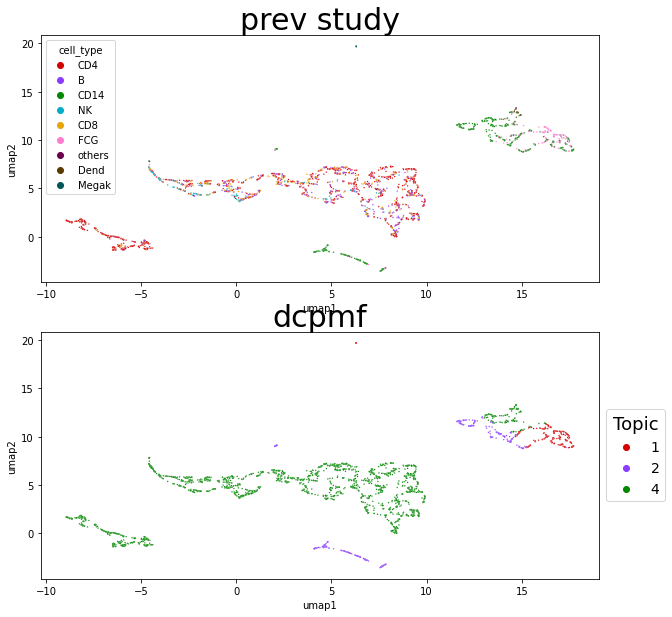

In [25]:
figure,axis = plt.subplots(2,1)
plt.rcParams["figure.figsize"] = (10,10)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("prev study",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("dcpmf",fontsize=30)